In [34]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
pd.options.display.float_format = '{:.6f}'.format

In [36]:
infile = "../data/features.csv"

In [37]:
%%time 
NROWS = 10000000
df = pd.read_csv(infile, index_col=0, nrows=NROWS)
print("{} rows".format(df.shape[0]))
print("{} columns".format(df.shape[1]))

263020 rows
13 columns
CPU times: user 1.19 s, sys: 97.5 ms, total: 1.29 s
Wall time: 1.29 s


In [38]:
df.head(1).T

ubisoft_id,dd8692d5-1d9d-4b0e-89e5-03a62643a4aa
platform,ps4
stats.normalized.accuracy,0.252235
stats.normalized.aggression,0.668391
stats.normalized.deaths.perhour,12.822747
stats.normalized.defensive_actions.perhour,20.069697
stats.normalized.kd,1.088944
stats.normalized.kills.perhour,13.963250
stats.normalized.losses.perhour,1.445430
stats.normalized.mobility,0.000701
stats.normalized.points.perbullet_fired,0.034937


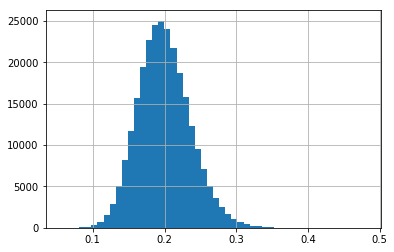

In [39]:
df['stats.normalized.accuracy'].hist(bins=50)
plt.show()

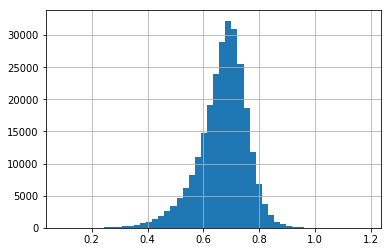

In [40]:
df['stats.normalized.aggression'].hist(bins=50)
plt.show()

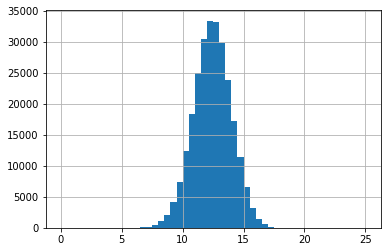

In [41]:
df['stats.normalized.deaths.perhour'].hist(bins=50, range=(0,25))
plt.show()

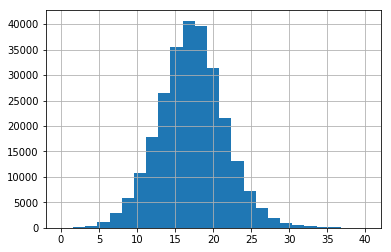

In [42]:
df['stats.normalized.defensive_actions.perhour'].hist(bins=25, range=(0,40))
plt.show()

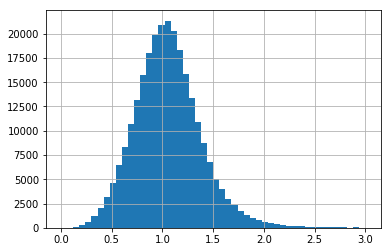

In [43]:
df['stats.normalized.kd'].hist(bins=50, range=(0,3))
plt.show()

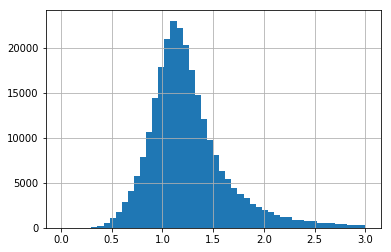

In [44]:
df['stats.normalized.wlr'].hist(bins=50, range=(0,3))
plt.show()

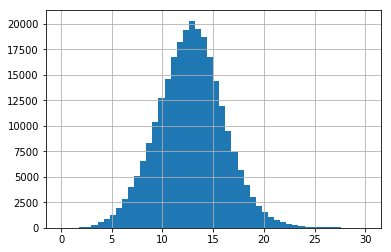

In [45]:
df['stats.normalized.kills.perhour'].hist(bins=50, range=(0,30))
plt.show()

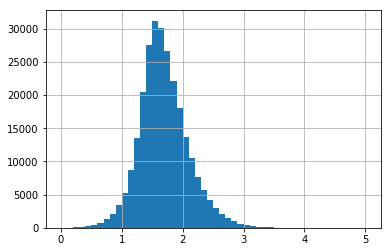

In [46]:
df['stats.normalized.losses.perhour'].hist(bins=50, range=(0,5))
plt.show()

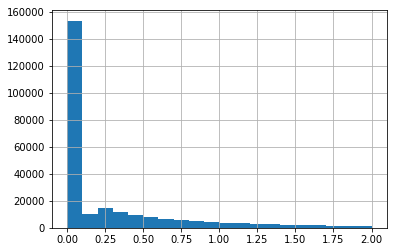

In [47]:
df['stats.normalized.mobility'].hist(bins=20, range=(0,2))
plt.show()

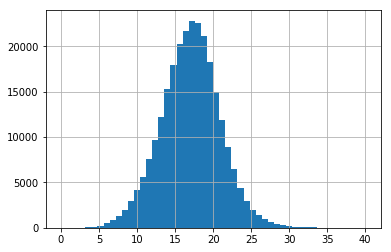

In [48]:
df['stats.normalized.points.perhour'].hist(bins=50, range=(0,40))
plt.show()

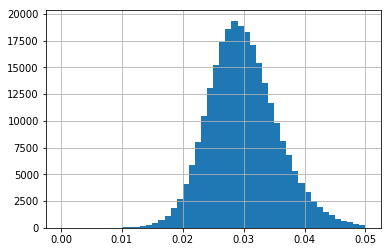

In [49]:
df['stats.normalized.points.perbullet_fired'].hist(bins=50, range=(0,0.05))
plt.show()

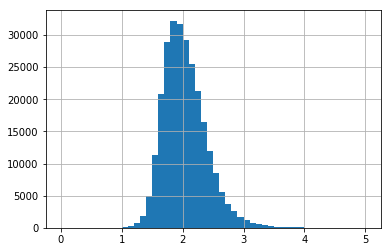

In [50]:
df['stats.normalized.wins.perhour'].hist(bins=50, range=(0,5))
plt.show()

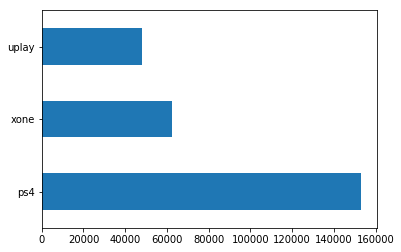

In [51]:
df['platform'].value_counts().plot(kind='barh')
plt.show()

In [52]:
# df_platform = pd.get_dummies(df['platform'])
# df = df.join(df_platform)
# df = df.drop('platform', axis=1)

In [53]:
# df['platform'] = df['platform'].replace({'ps4': 1, 'uplay': 2, 'xone': 3})

In [54]:
df = df.drop('platform', axis=1)

In [55]:
df.head(1).T

ubisoft_id,dd8692d5-1d9d-4b0e-89e5-03a62643a4aa
stats.normalized.accuracy,0.252235
stats.normalized.aggression,0.668391
stats.normalized.deaths.perhour,12.822747
stats.normalized.defensive_actions.perhour,20.069697
stats.normalized.kd,1.088944
stats.normalized.kills.perhour,13.963250
stats.normalized.losses.perhour,1.445430
stats.normalized.mobility,0.000701
stats.normalized.points.perbullet_fired,0.034937
stats.normalized.points.perhour,17.903532


In [56]:
from sklearn.decomposition import pca
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [57]:
%%time 
scaler = MinMaxScaler(feature_range=(-1,1), copy=True).fit(df)
# scaler = StandardScaler(copy=True).fit(df)

X_scaled = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

reducer = pca.PCA(n_components=2, whiten=True).fit(X_scaled)
X_pca = pd.DataFrame(reducer.transform(X_scaled), index=X_scaled.index, columns=['pca1', 'pca2'])
X_pca.head()

CPU times: user 1.02 s, sys: 395 ms, total: 1.41 s
Wall time: 775 ms


In [58]:
X = X_pca.copy().sample(n=25000).values
X

array([[-0.86893423,  0.91801409],
       [-1.01444064, -1.58750262],
       [-0.27936332, -2.28616424],
       ..., 
       [ 0.52779971, -0.36922584],
       [-2.61480749, -0.23121571],
       [-0.22702317,  1.2413455 ]])

In [59]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 4 The average silhouette_score is : 0.312451038505


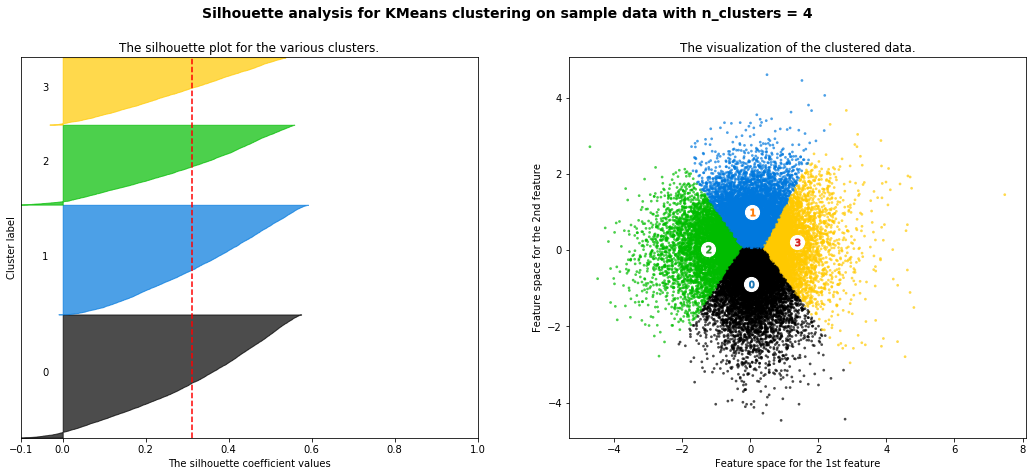

For n_clusters = 5 The average silhouette_score is : 0.303885595718


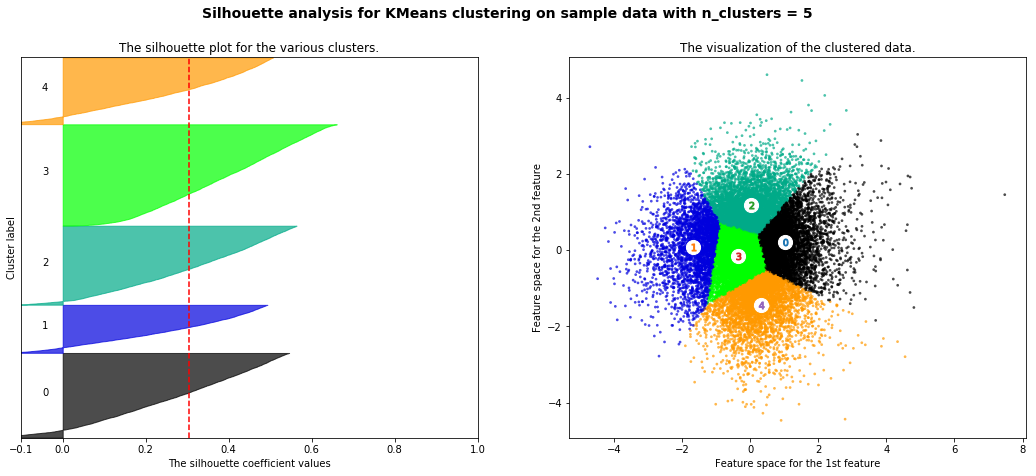

For n_clusters = 6 The average silhouette_score is : 0.296019832441


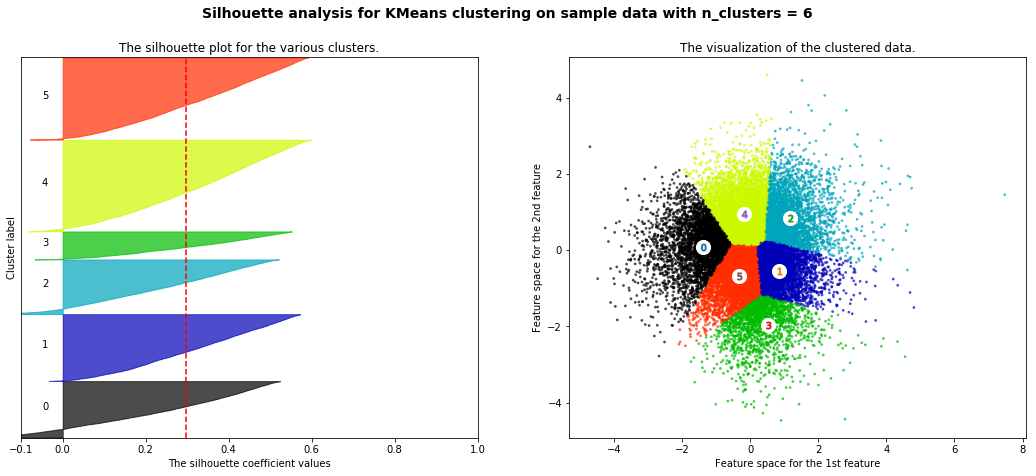

For n_clusters = 7 The average silhouette_score is : 0.307834224341


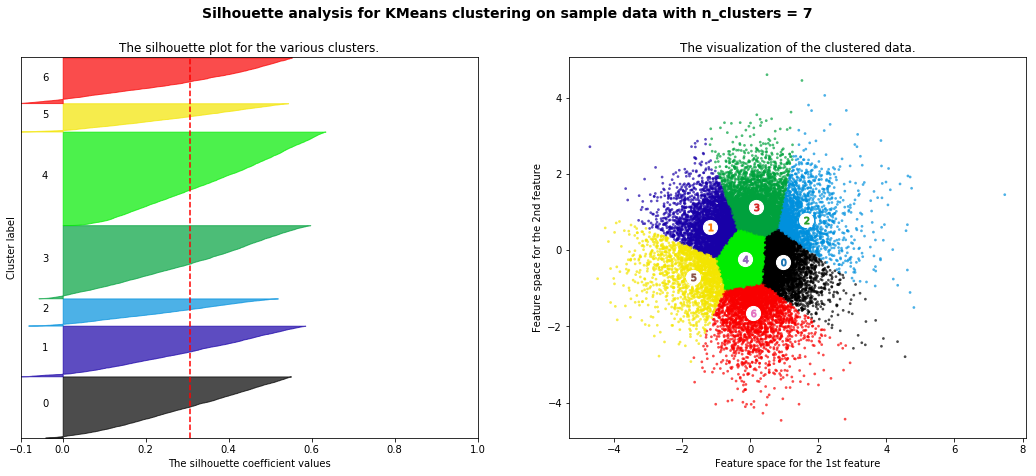

For n_clusters = 8 The average silhouette_score is : 0.286196875562


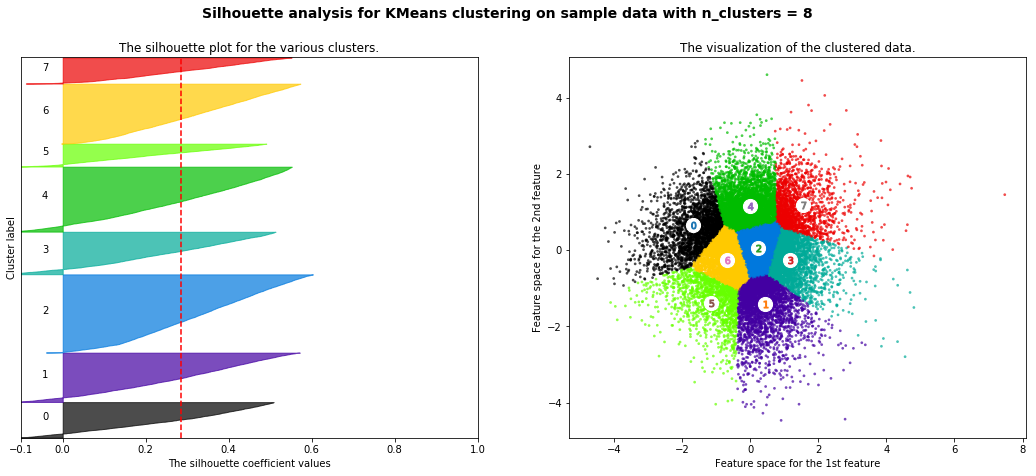

For n_clusters = 9 The average silhouette_score is : 0.282199483869


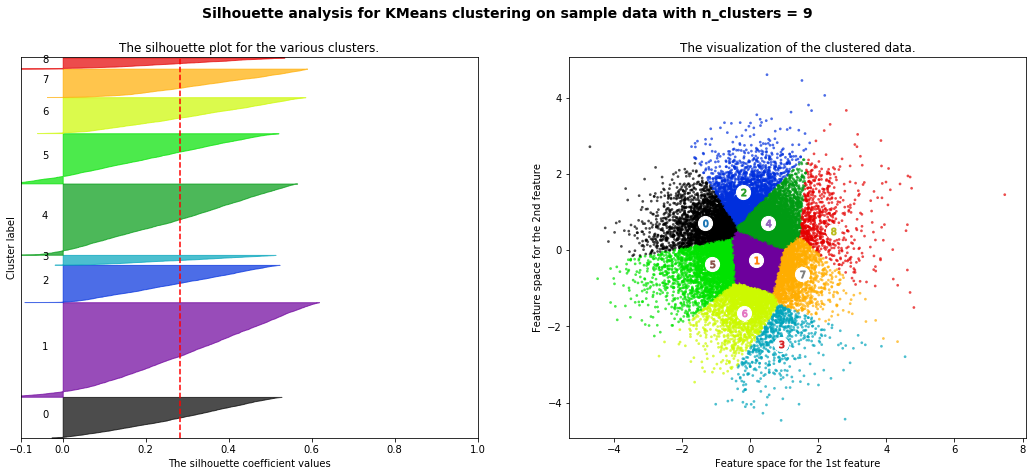

For n_clusters = 10 The average silhouette_score is : 0.299869078021


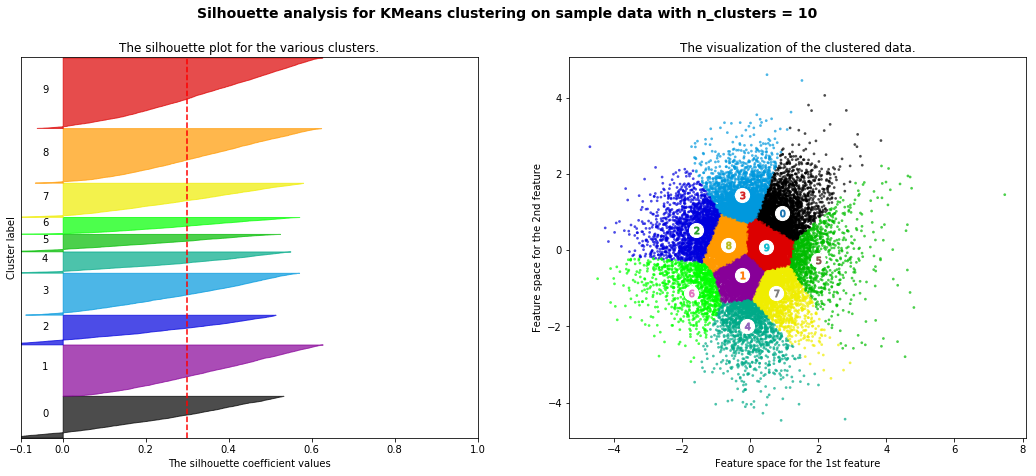

CPU times: user 6min 5s, sys: 1min 29s, total: 7min 35s
Wall time: 7min 13s


In [60]:
%%time 
range_n_clusters = range(4, 11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=45,
                      n_init=10, max_no_improvement=10, verbose=0)

    # clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=3)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [61]:
print(X[:, 0].mean())
print(X[:, 1].mean())

-0.00326779790827
0.00723143459456


In [62]:
reducer.explained_variance_ratio_

array([ 0.47013428,  0.16670765])

In [63]:
print(df.shape)
print(X_pca.shape)

(263020, 12)
(263020, 2)


In [64]:
%%time 
clusterer = MiniBatchKMeans(init='k-means++', n_clusters=6, batch_size=45,
                  n_init=10, max_no_improvement=10, verbose=0)

# clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=3)
cluster_labels = clusterer.fit_predict(X_pca)

CPU times: user 958 ms, sys: 7.4 ms, total: 965 ms
Wall time: 964 ms


In [65]:
df['label'] = cluster_labels.astype(int)

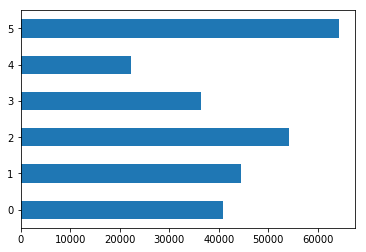

CPU times: user 227 ms, sys: 32 ms, total: 259 ms
Wall time: 258 ms


In [66]:
%%time 
pd.value_counts(df['label'], sort=False).plot(kind='barh')
plt.show()